# AdaBoost

### Fit

1. Initialize weight for each sample $w_0 = \frac{1}{N}$
2. Train $n$ classifiers

### Training
1. Initialize weak classifier (decision stump)
2. Using greedy search loop over all features and threshold
3. Calculate the error $\epsilon$ = sum of weights associated with each misclassified sample for each (feature, threshold) pair
4. If $\epsilon \geq 0.5$, flip $\epsilon$ to $1 - \epsilon$ and polarity to -1
5. When the smallest $\epsilon$ is obtained store the current polarity, feature and threshold 
6. After greedy search calculate $\alpha = 0.5 \log \left( \frac{1 - \epsilon}{\epsilon} \right)$
7. Update weights $\mathbf{w_{n + 1}} = \mathbf{w_{n}} \cdot \exp(- \alpha \cdot \mathbf{y} \cdot h(\mathbf{X}))$
8. Normalize weights $\mathbf{w_{n + 1}} = \frac{\mathbf{w_{n + 1}}}{\left || \mathbf{w_{n + 1}} \right ||}$

### Predict
1. Calculate $ \text{sgn} \left( \sum_{i}^{n} \alpha_i \cdot h_i(\mathbf{X}) \right)$

In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
def plot_2d_clf_problem(X, y, h=None):
    '''
    Plots a two-dimensional labeled dataset (X,y) and, if function h(x) is given, 
    the decision surfaces.
    '''
    assert X.shape[1] == 2, "Dataset is not two-dimensional"
    if h!=None : 
        # Create a mesh to plot in
        r = 0.03  # mesh resolution
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, r),
                             np.arange(y_min, y_max, r))
        XX=np.c_[xx.ravel(), yy.ravel()]
        try:
            Z_test = h(XX)
            if Z_test.shape == ():
                # h returns a scalar when applied to a matrix; map explicitly
                Z = np.array(list(map(h,XX)))
            else :
                Z = Z_test
        except ValueError:
            # can't apply to a matrix; map explicitly
            Z = np.array(list(map(h,XX)))
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)

    # Plot the dataset
    plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.tab20b, marker='o', s=50);

In [8]:
class DecisionStump:

    def __init__(self) -> None:
        """
        Decision Stump is a Decision Tree with two leaf nodes and one decision node. Its primary use is being a weak classifier upon which
        the AdaBoost classifier is built.

        Attributes
        ----------
        polarity : int, default=1
            Determines how the feature space is split into positive and negative classes. If the value of polarity is -1
            the positive and negative classses are switched.
        
        feature_index : int
            Index of the feature column which is used as the feature space for the Decision Stump.

        threshold : numpy.float64
            Value that best splits the feature space into positive and negative classes.

        alpha : numpy.float64
            Weight assigned to the Decision Stump based on its performance.
        """
        self.polarity = 1
        self.feature_index = None
        self.threshold = None
        self.alpha = None

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predict using the Decision Stump.

        Parameters
        ----------
        X : numpy.ndarray
            Samples of shape (n_samples, n_features).

        Returns
        -------
        y : numpy.ndarray
            Predicted values of shape (n_samples,).
        """
        n_samples = X.shape[0]
        X_column = X[:, self.feature_index]
        predictions = np.ones(n_samples)

        if self.polarity == 1:
            predictions[X_column < self.threshold] = -1
        else:
            predictions[X_column > self.threshold] = -1

        return predictions
    
class AdaBoost:

    def __init__(self, n_classifiers=5) -> None:
        """
        AdaBoost classifier is an ensemble method which consists of training 
        a number of weak classifiers that correct the mistakes of its predecessors.
        All weak classifiers are trained on the same dataset.

        Parameters
        ----------
        n_classifiers : int, default=5
            Number of weak classifiers to train. 
        """
        self.n_classifiers = n_classifiers

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        """
        Fit an AdaBoost classifier.

        Parameters
        ----------
        X : numpy.ndarray
            Training data of shape (n_samples, n_features).

        y : numpy.ndarray
            Target values of shape (n_samples,).

        Returns
        -------
        None
        """
        # Extract number of samples and number of features
        n_samples, n_features = X.shape

        # Initialize weights for each sample
        w = np.ones(n_samples) / n_samples

        # Create an empty list of classifiers
        self.classifiers = []

        # Train n classifiers
        for _ in range(self.n_classifiers):

            # Initialize a Decision Stump
            clf = DecisionStump()

            # Initialize minimum error
            min_error = float('inf')

            # Iterate throught all the feature indices
            for feature_index in range(n_features):
                
                # Select a column using its feature index
                X_column = X[:, feature_index]
                # Get unique values from the column
                thresholds = np.unique(X_column)

                # Iterate through all the thresholds
                for threshold in thresholds:

                    # Initialize polarity to 1
                    p = 1
                    # Initialize predictions to a vector of ones
                    predictions = np.ones(n_samples)
                    # Set the prediction for samples that are beneath the threshold to -1
                    predictions[X_column < threshold] = -1

                    # Get the weights of the misclassified samples
                    misclassified = w[y != predictions]
                    # Sum the misclassified weights
                    error = sum(misclassified)

                    if error > 0.5:
                        error = 1 - error
                        # Swap the polarity to -1
                        p = -1

                    if error < min_error:
                        min_error = error
                        # Set the polarity of the current classifier
                        clf.polarity = p
                        # Store the best threshold for the current classifier
                        clf.threshold = threshold
                        # Store the feature index for the current classifier
                        clf.feature_index = feature_index

            # Calculate alpha for the current classifier   
            clf.alpha = 0.5 * np.log((1 - error) / (error + 1e-10))
            # Predict using the current classifer
            predictions = clf.predict(X)

            # Update the weights
            w *= np.exp(-clf.alpha * y * predictions)
            w /= sum(w)

            # Store the current classifer
            self.classifiers.append(clf)

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predict using the AdaBoost classifer.

        Parameters
        ----------
        X : numpy.ndarray
            Samples of shape (n_samples, n_features).

        Returns
        -------
        y : numpy.ndarray
            Predicted values of shape (n_samples,).
        """
        return np.sign(np.sum([clf.alpha * clf.predict(X) for clf in self.classifiers], axis=0))


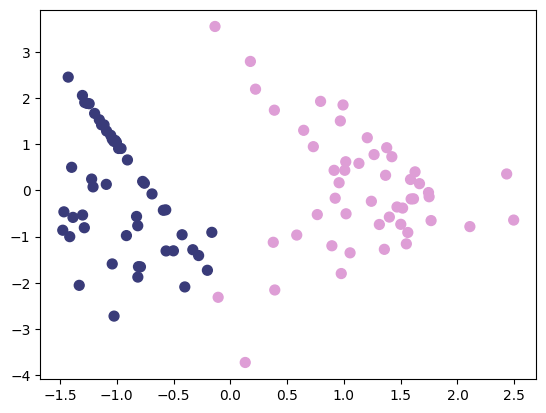

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=100, n_features=2, n_classes=2, n_informative=2, n_redundant=0)
y = np.where(y != 1, -1, 1)
plot_2d_clf_problem(X, y)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Accuracy: 1.0


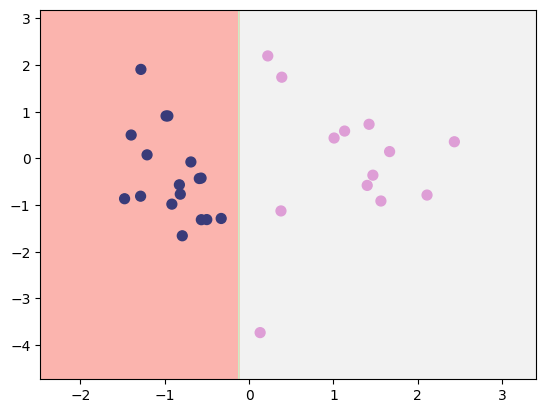

In [21]:
model = AdaBoost()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(f'Accuracy: {np.mean(y_pred == y_test)}')

plot_2d_clf_problem(X_test, y_test, model.predict)
plt.show()